# Optimizing JupyterHub startup time

This is some analysis of timings for optimizing JupyterHub startup time while avoiding shifting that time too much to single subsequent requests.

Specifically for [jupyterhub#4496](https://github.com/jupyterhub/jupyterhub/pull/4496)

In [118]:
import pandas as pd
import matplotlib.pyplot as plt

Each run is stored in a CSV file, with three measurements:

- startup: the total startup time of JupyterHub
- spawn: the time for init_spawners only (typically dominates startup)
- first_users: the time to complete the first GET /api/users request
- second_users: the time to complete the second GET /api/users request,
  which should be typical of subsequent requests, e.g. by the idle culler

In [49]:
stable = pd.read_csv('7ae1b0b.csv')

In [50]:
stable.tail()

,users,active,running,startup,spawn,first_users,second_users
16,2000,0.25,500,12.757374,3.637875,17.449388,0.404349
17,2000,1.00,2000,19.610846,10.435888,10.461458,0.383812
18,5000,0.00,0,20.871420,0.004117,47.202517,1.486098
19,5000,0.25,1250,30.896910,9.378548,43.738452,1.337878
20,5000,1.00,5000,49.238456,26.894007,32.661048,1.465979


The `generate-data` script runs `startup-perf` to gather data for each commit in the PR.

In [119]:
import os

jupyterhub_dir = os.path.expanduser("~/dev/jpy/jupyterhub")
BASE_REF = "origin/main"
BRANCH = "quicker-startup"

from subprocess import check_output

all_refs = [
    check_output(
        ["git", "show", "-s", "--format=%H", BASE_REF], cwd=jupyterhub_dir, text=True
    ).strip()
]

all_refs.extend(
    check_output(
        ["git", "rev-list", f"{BASE_REF}..{BRANCH}"], cwd=jupyterhub_dir, text=True
    ).split()[::-1]
)

# ignore some commits that have bugs preventing them from producing valid data
broken = set()
all_refs

['7ae1b0b97fb550c2c621f9294416bf779f35f09f',
 '55e4ed6c072b224f795e4ee73aae9204aaf59bbb',
 'e50ad5f0394af14b87fc891a3867c1185a33b632',
 'de31e7f815e98f5da6c613f2568c064300b4b72b']

In [120]:
csvs = [ f"{ref[:7]}.csv" for ref in all_refs if ref not in broken]
csvs

['7ae1b0b.csv', '55e4ed6.csv', 'e50ad5f.csv', 'de31e7f.csv']

Load the CSV files into data frames

In [121]:
names = []
frames = []

for csv in csvs:
    if os.path.exists(csv):
        print(f"Loading {csv}")
        name, _ = os.path.splitext(csv)
        names.append(name)
        frames.append(pd.read_csv(csv))

stable = frames[0]
latest = frames[-1]

Loading 7ae1b0b.csv
Loading 55e4ed6.csv
Loading e50ad5f.csv
Loading de31e7f.csv


We can plot our three metrics for a given commit:

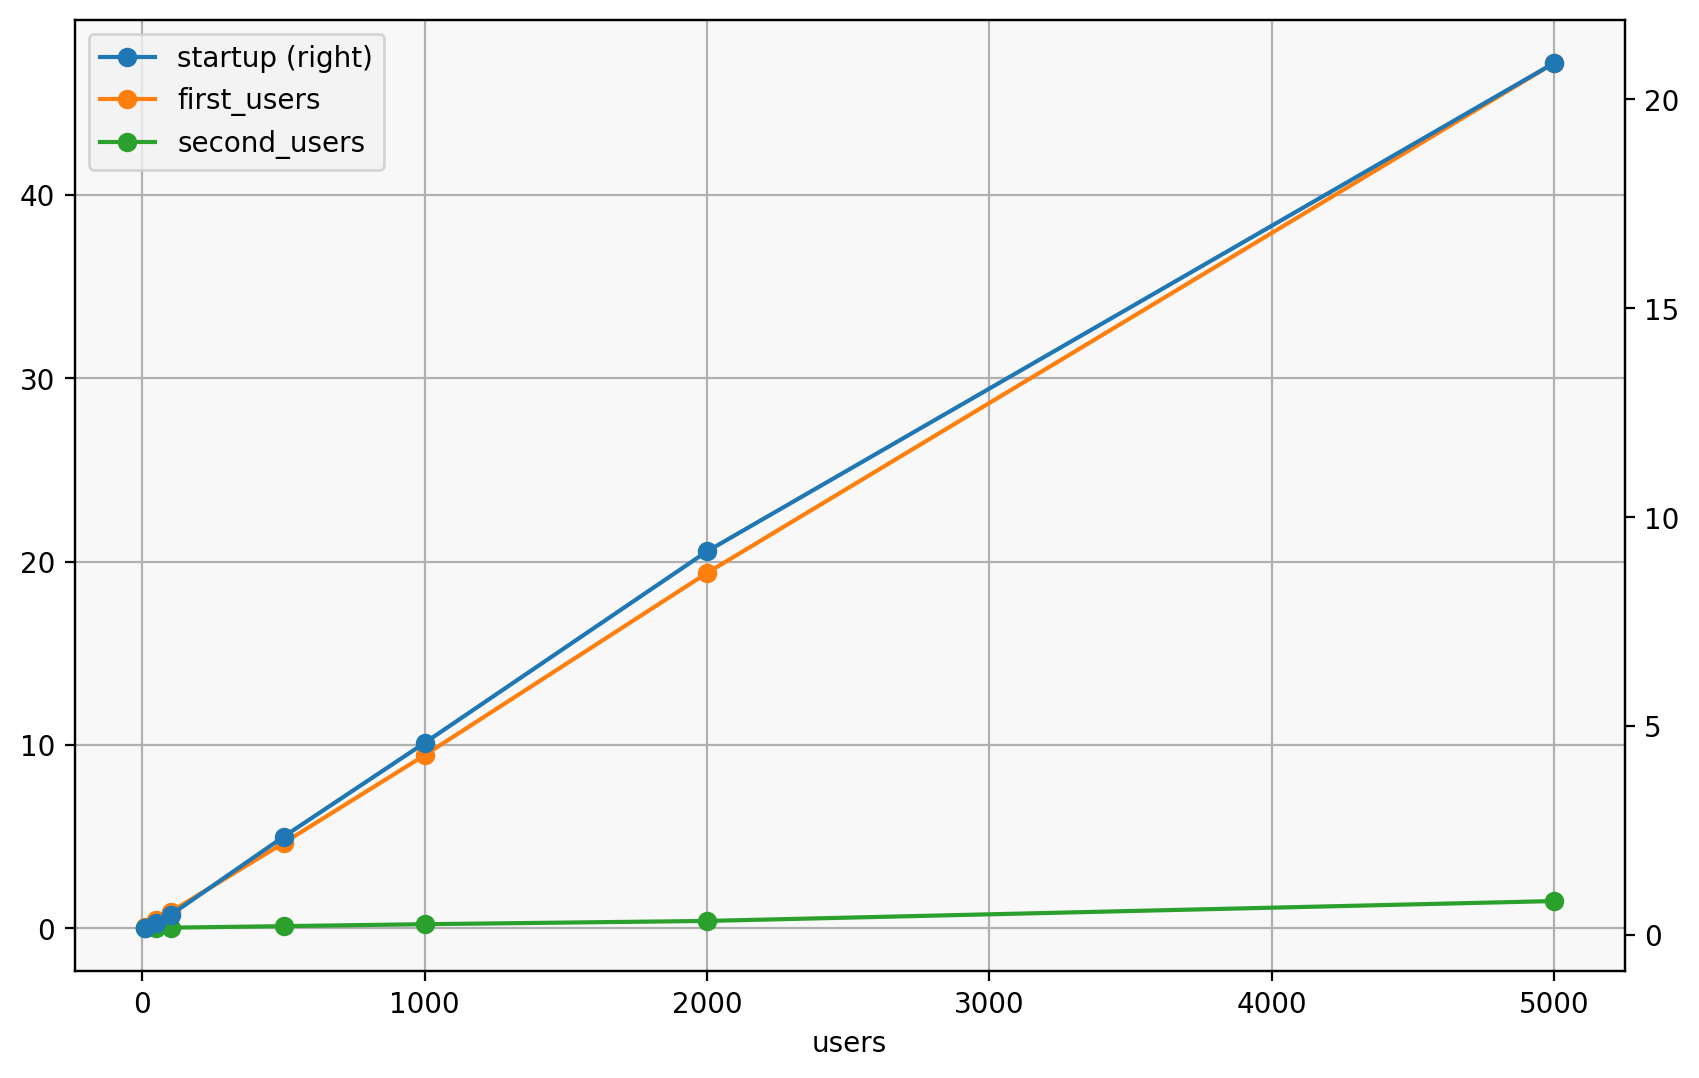

In [122]:
def plot_active(df, active=0):
    df = df[df.active == active]
    # df.plot(x='users', y='startup')
    # plt.title("Startup times")
    df.plot(x='users', y=['startup', 'first_users', 'second_users'], secondary_y=['startup'], style='-o')
    # plt.title("GET /api/users")

plot_active(stable)

Plot startup time vs active users. This is the biggest thing we are changing

In [123]:
def plot_vs_running(df):
    user_counts = df.users.unique()
    for u in user_counts:
        data = df[df.users==u]
        plt.semilogx(data.running + 1, data.startup, '-o', label=f'{u} users')
    plt.legend(loc=0)
    plt.title("Startup time")
    plt.xlabel("active users")
    plt.ylabel("Seconds")


In 4.1, startup has a high cost per-user (up to 50 seconds for 5000 active users!),
as well as per active user.


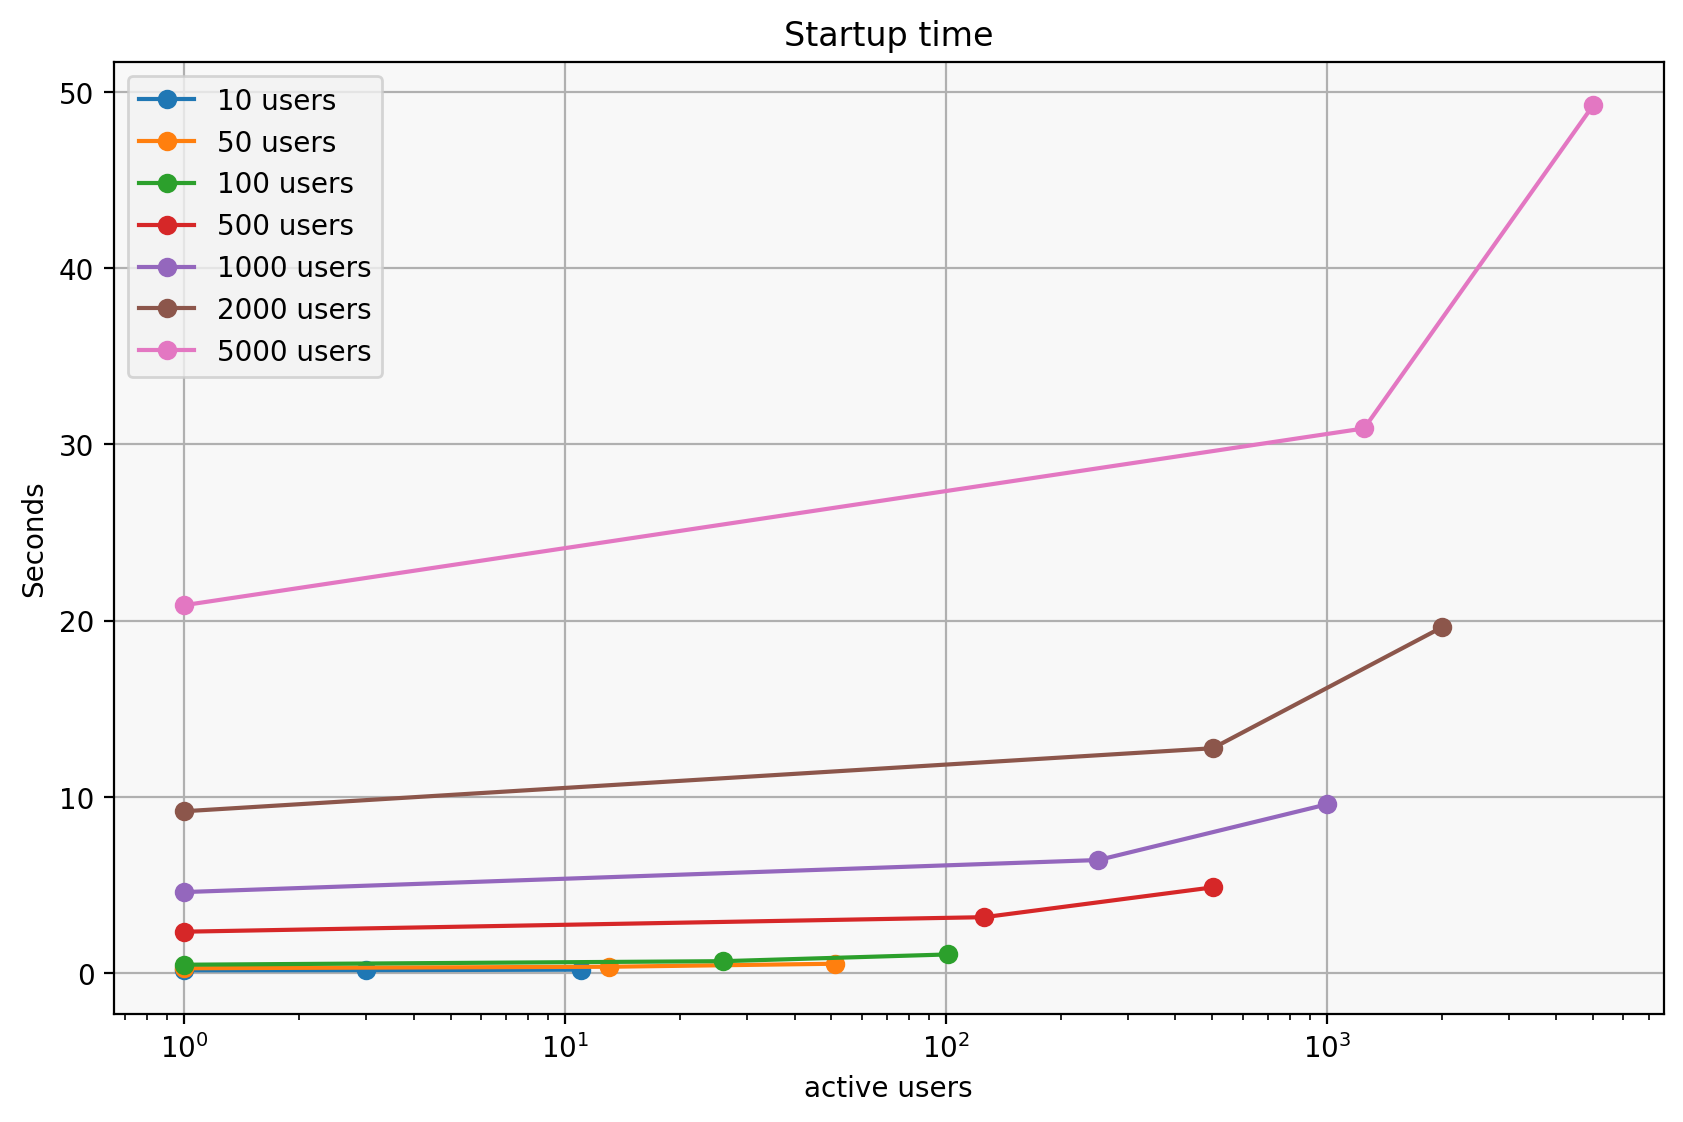

In [124]:
plot_vs_running(stable)

With the latest update, startup time is now much faster, and extra quick when few users were running at startup time (typically true).

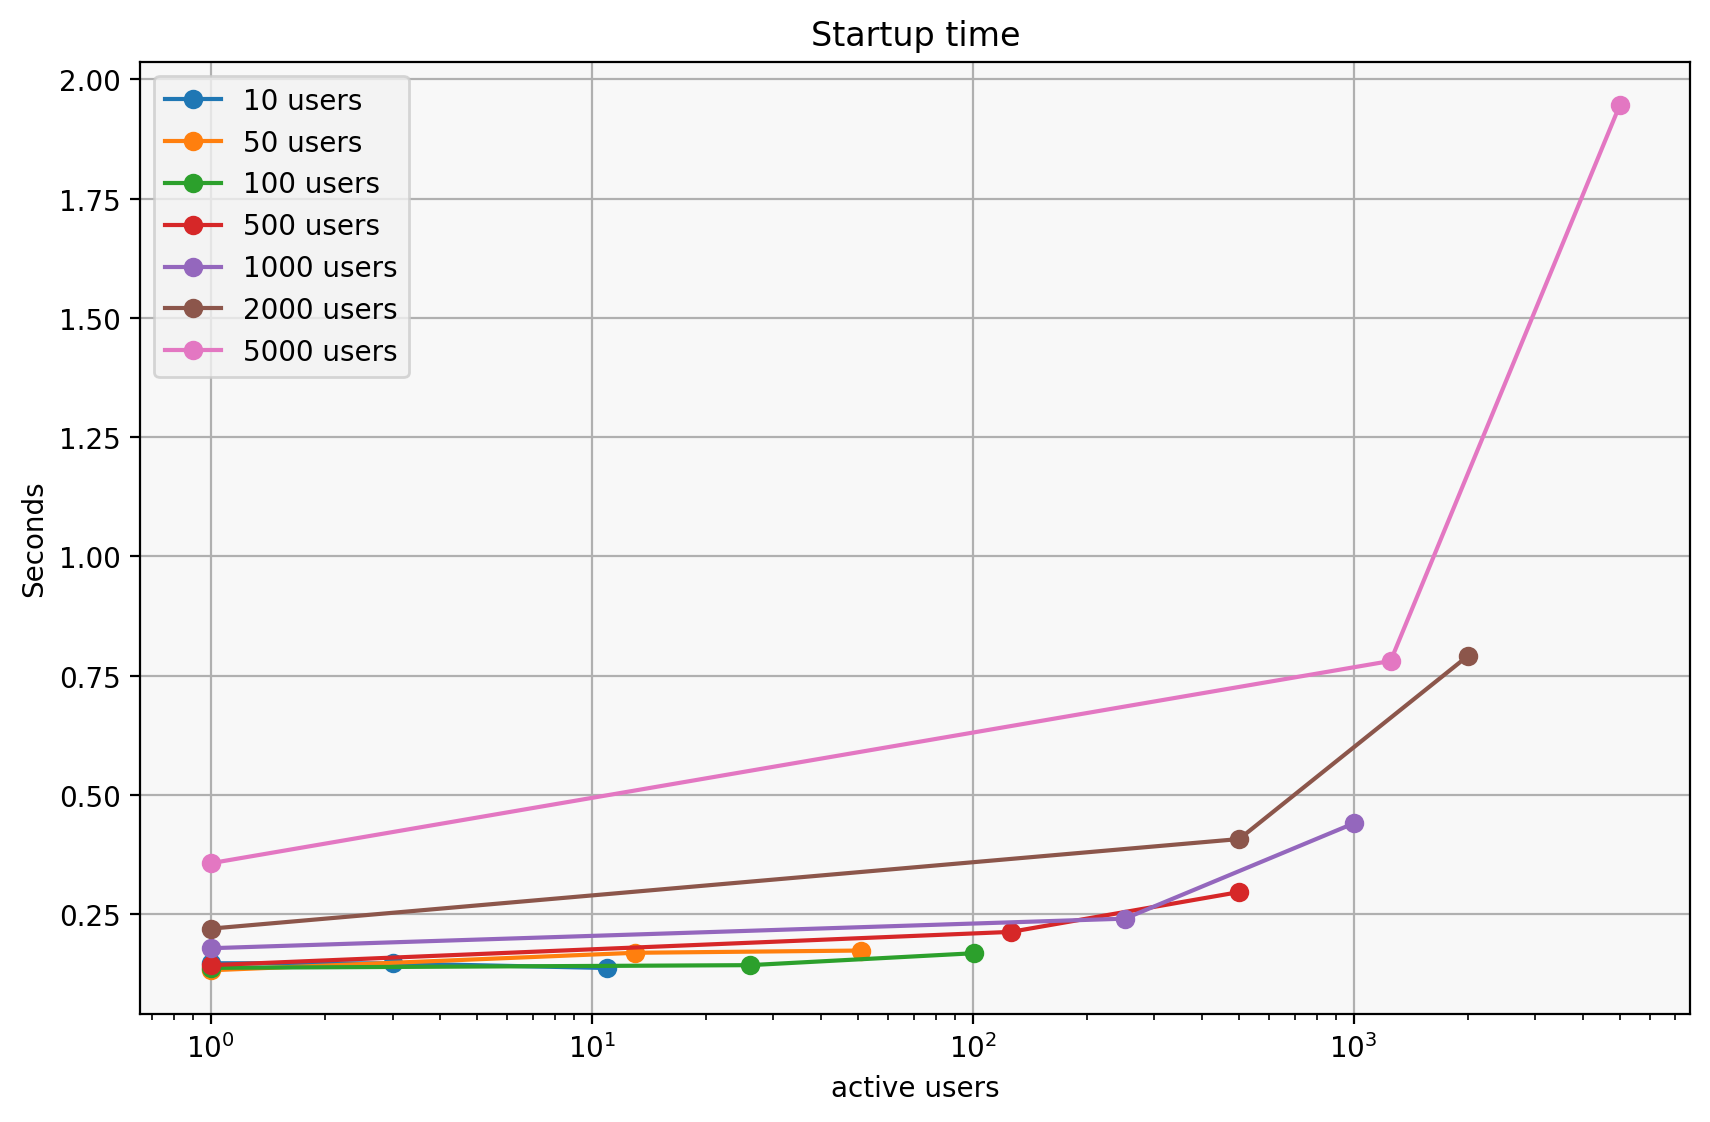

In [83]:
plot_vs_running(frames[-1])

Now we can try to compare our three metrics (startup time, first GET /api/users, second GET /api/users) across the commits.

In [125]:
import altair as alt

df = frames[-1]
alt.Chart(df).mark_line(
    point={
        "filled": False,
        "fill": "white",
    }
).encode(
    x=alt.X("running", title="% active"), #scale=alt.Scale(type="log")),
    y=alt.Y("startup", title="startup time (s)"),
    color="users:O",
)

alt.Chart(...)

In [127]:
column_labels = {
    "spawn": "Spawner initialization",
}

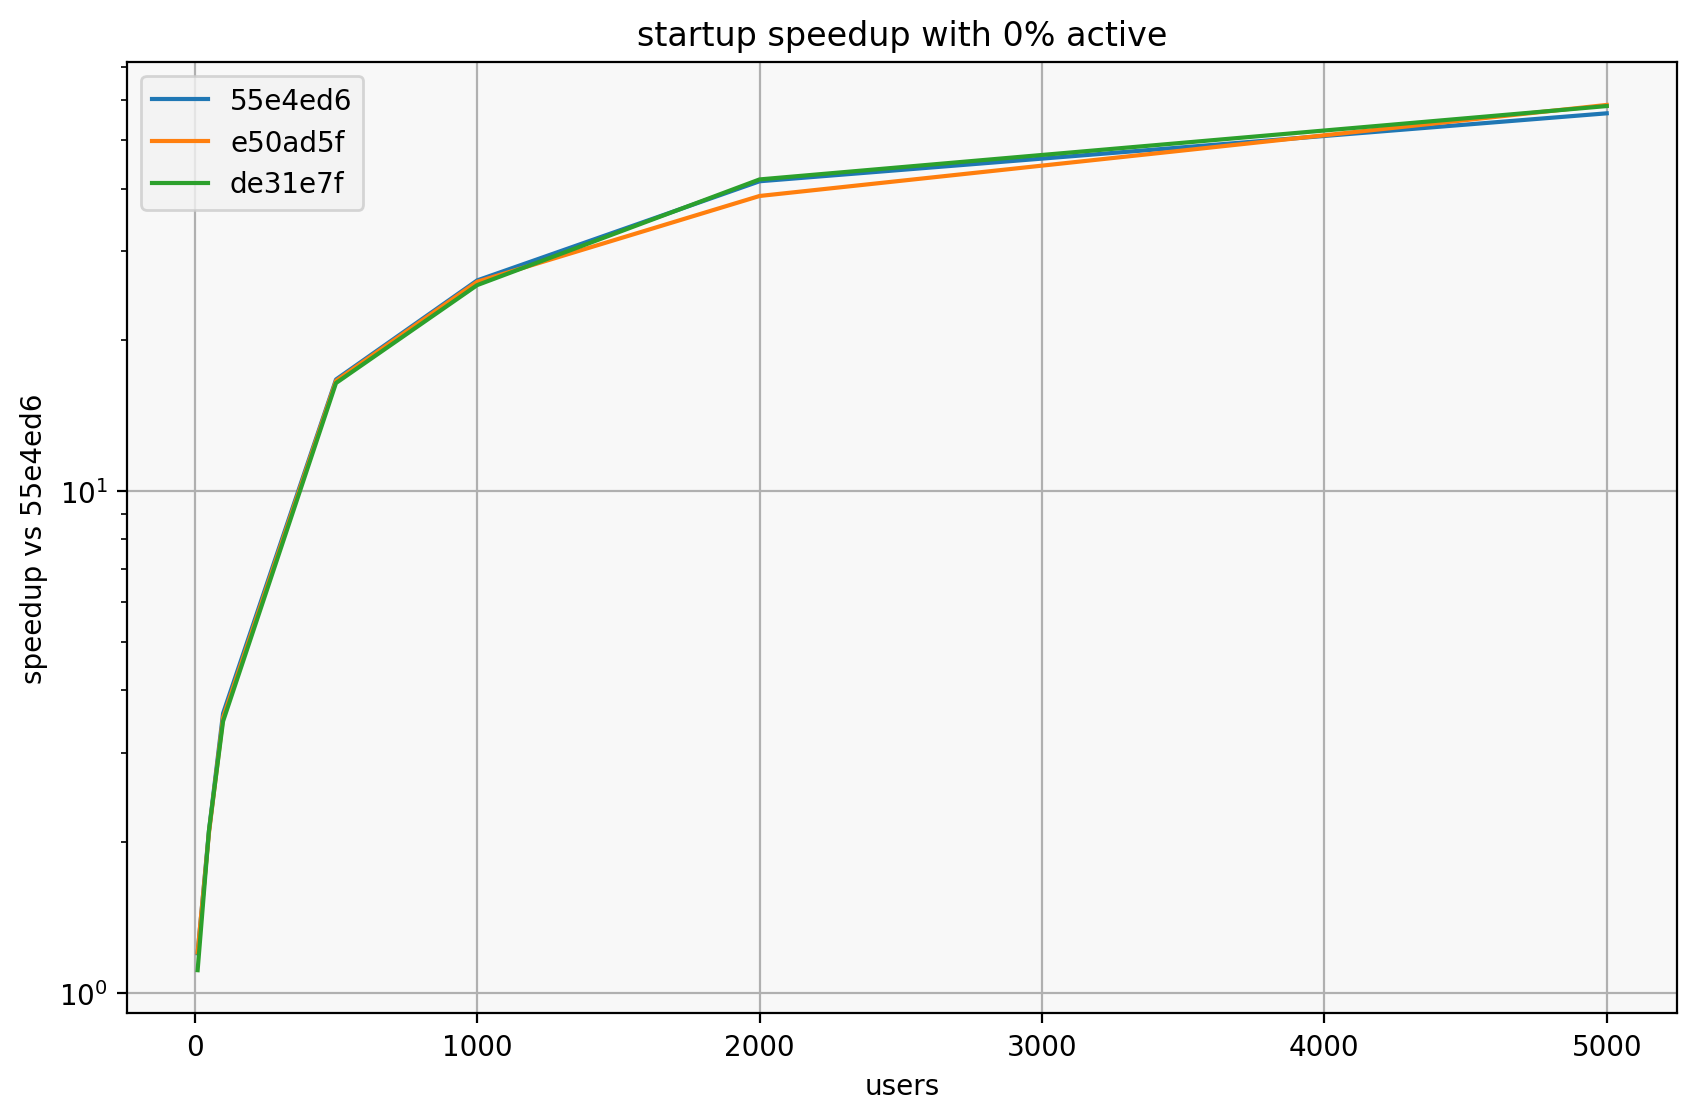

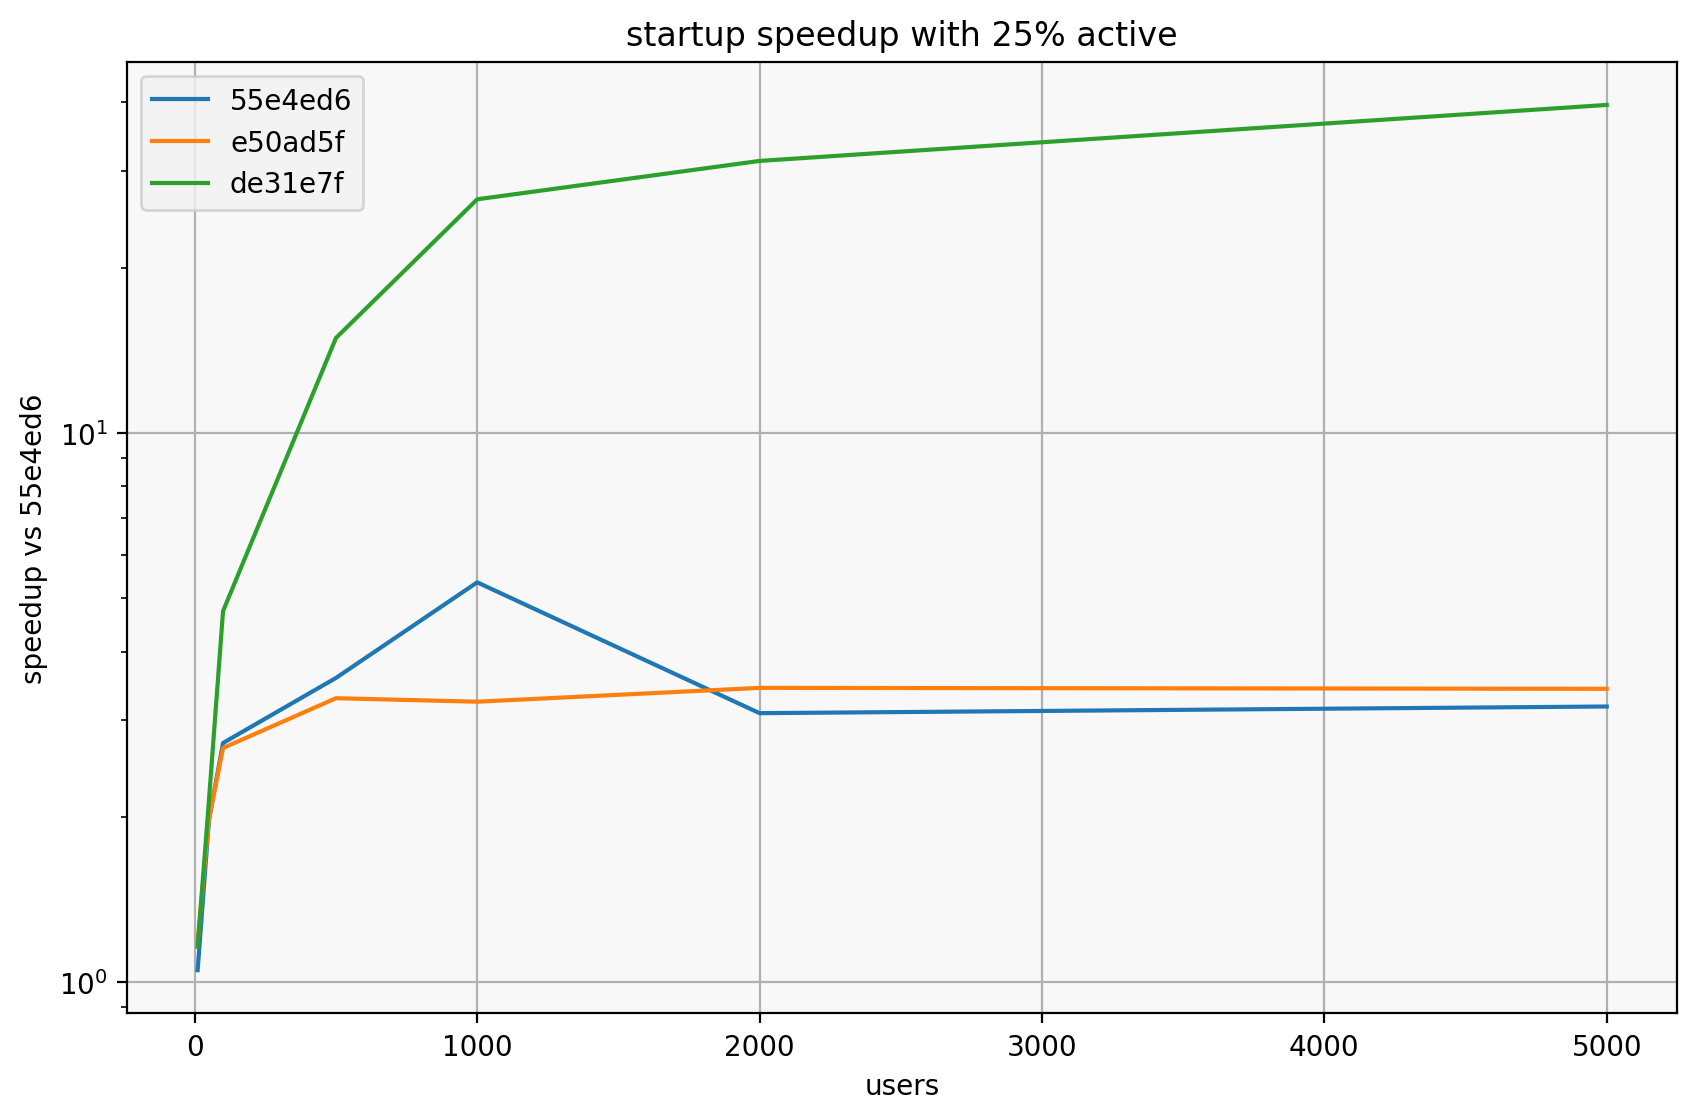

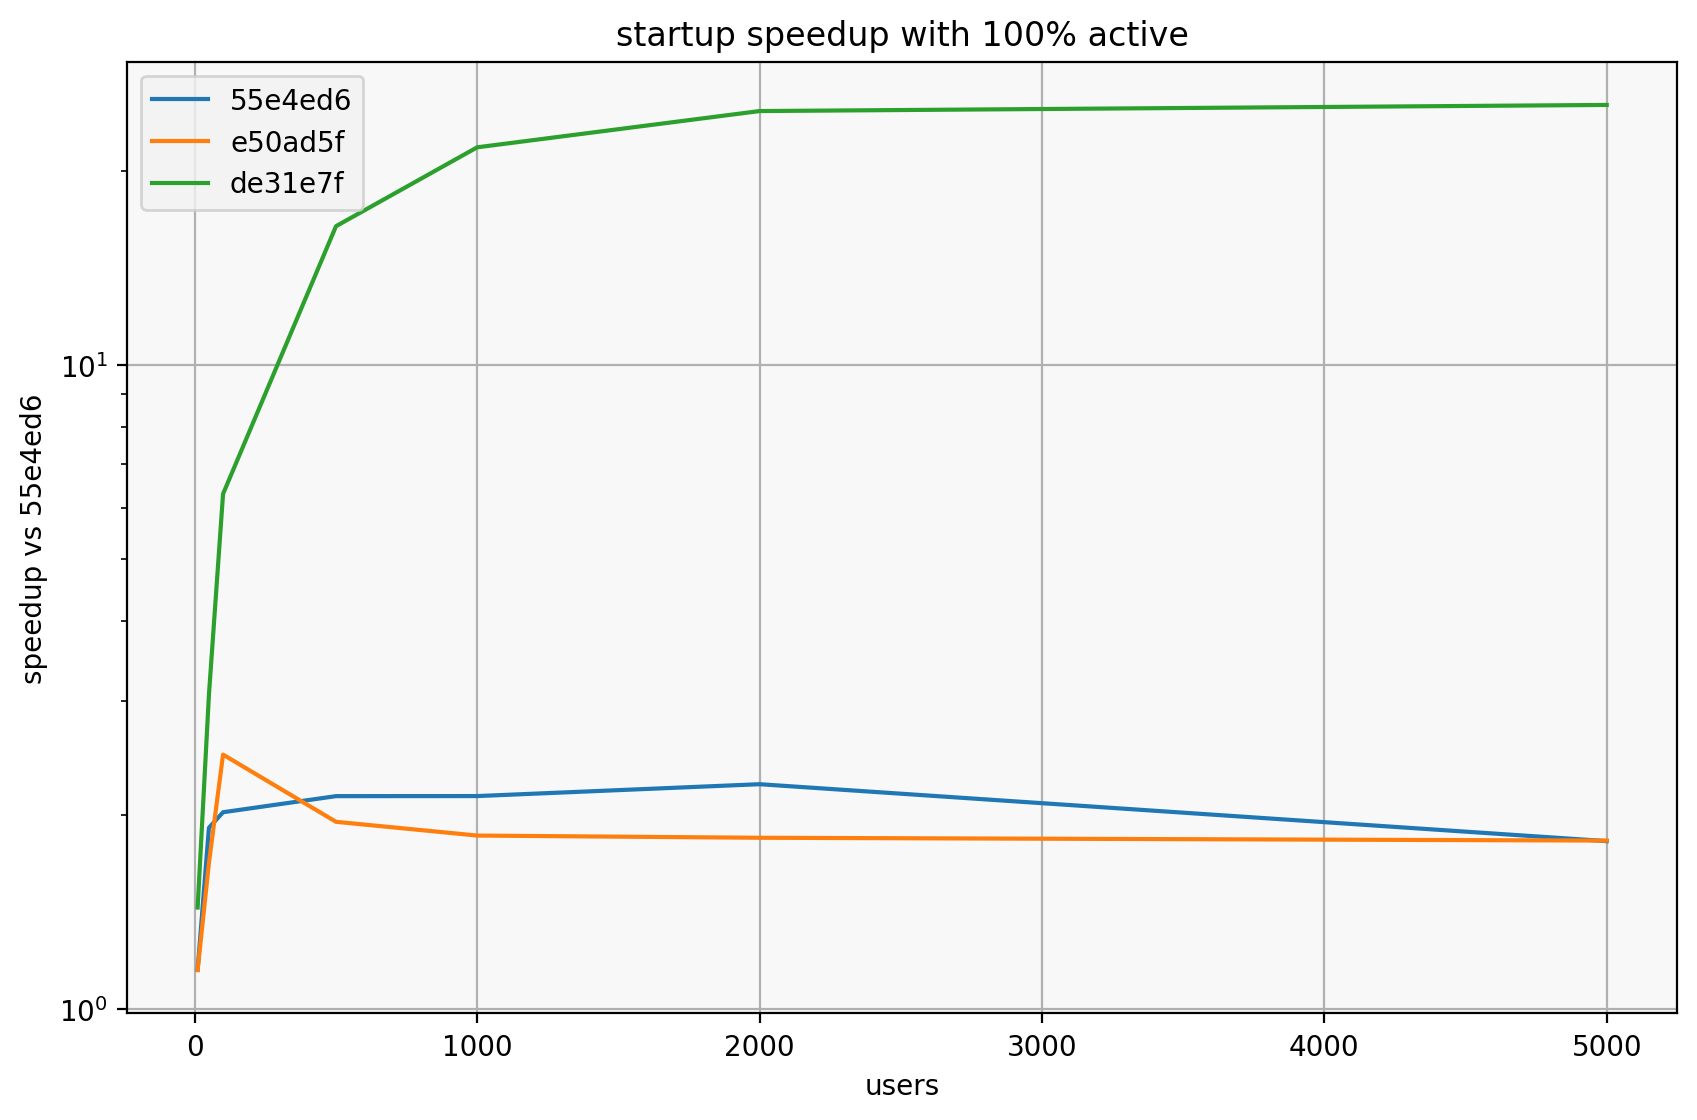

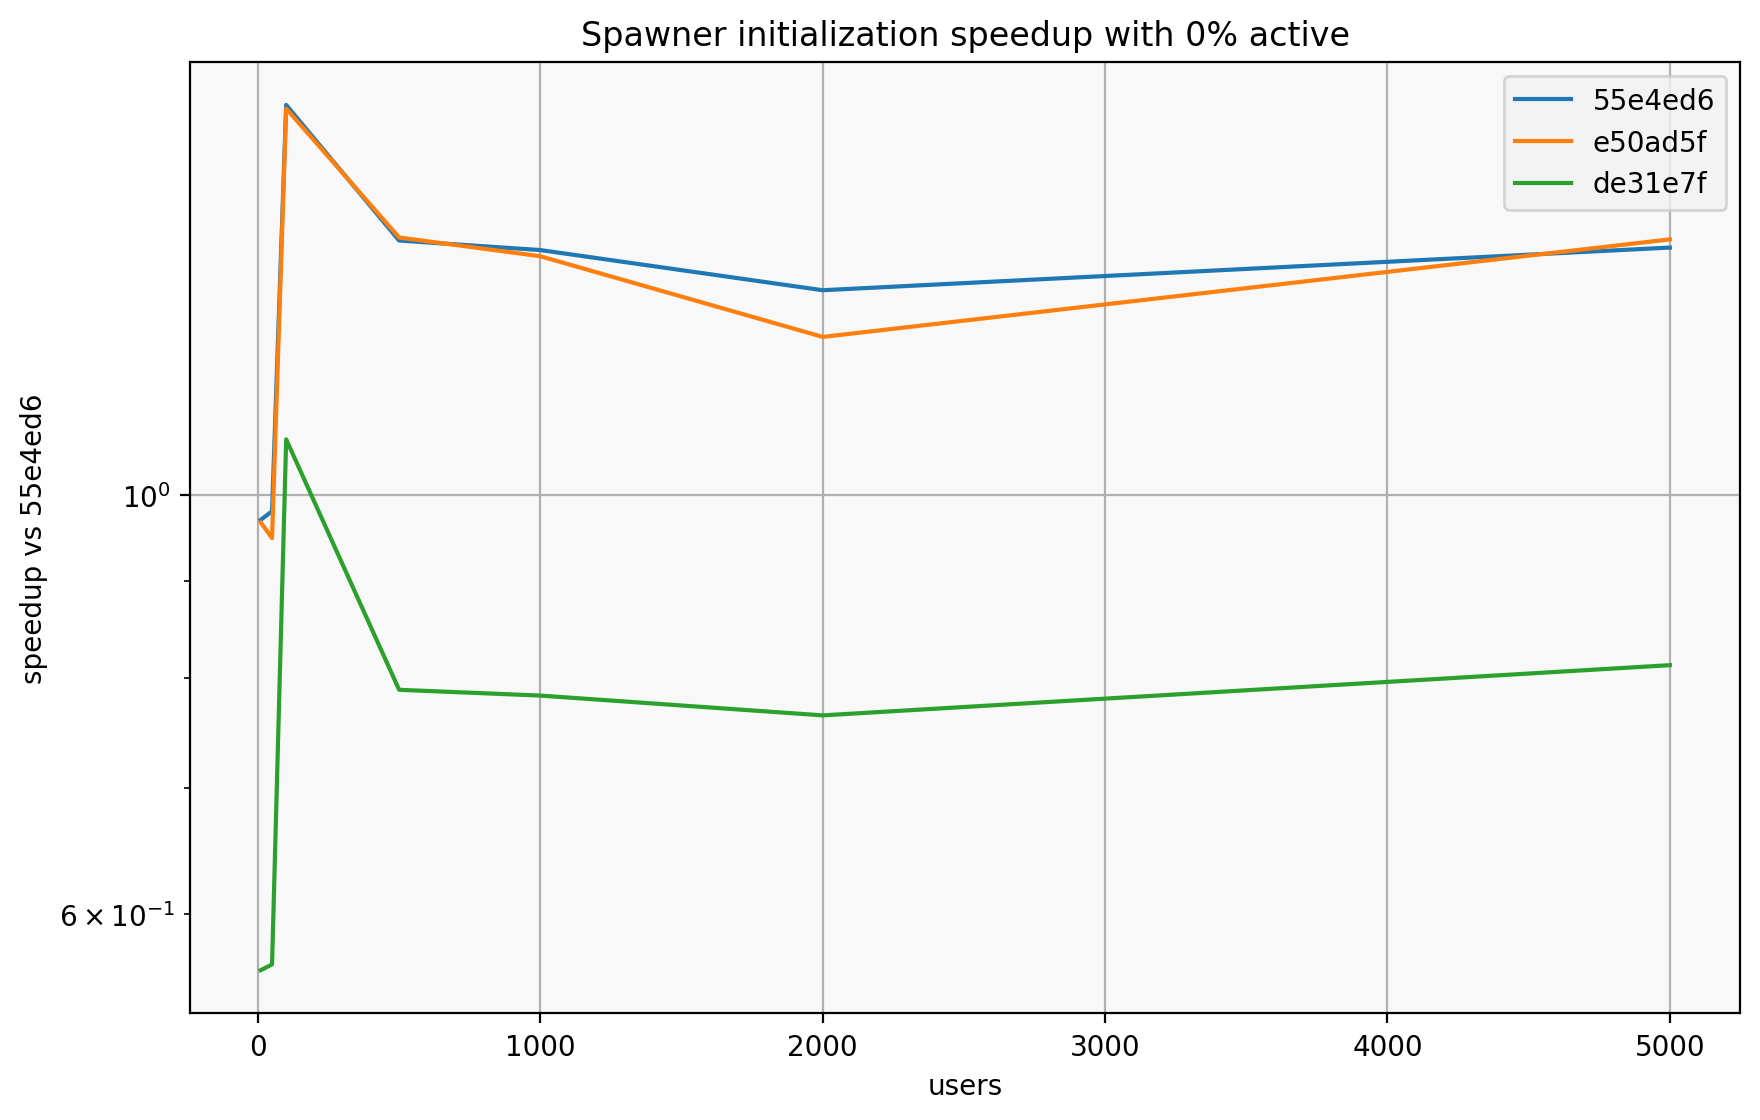

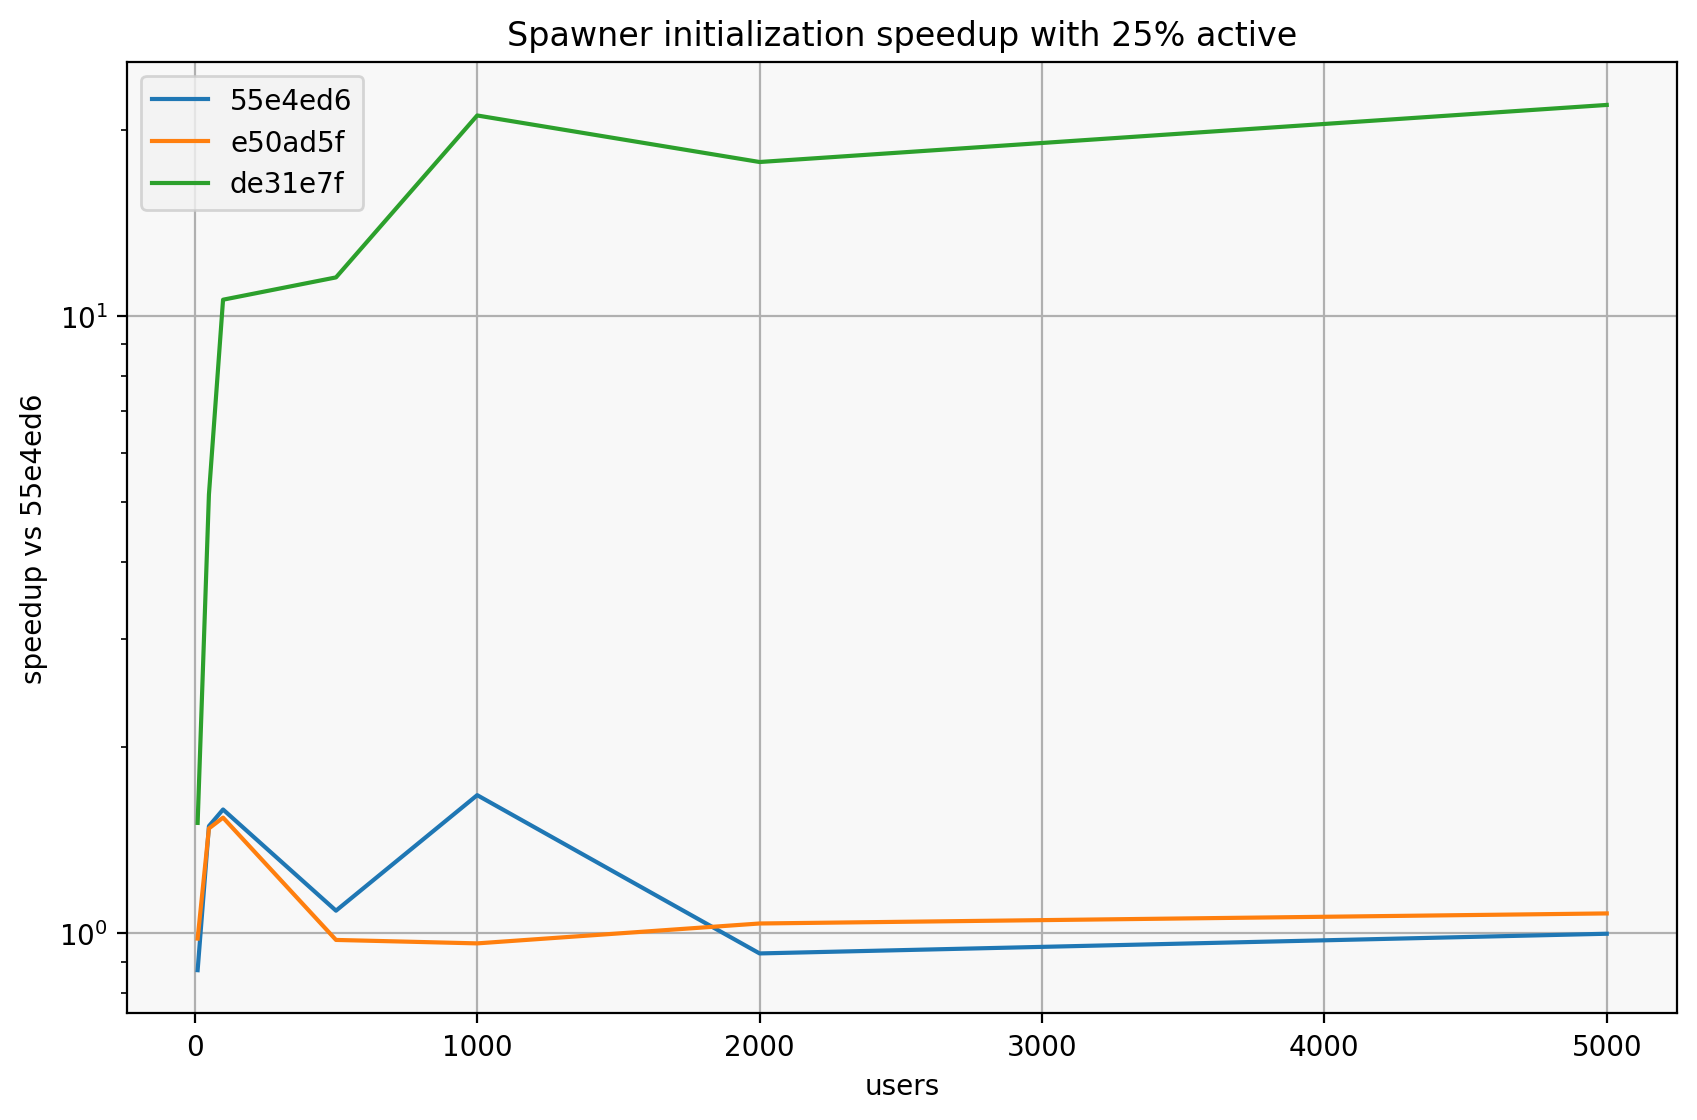

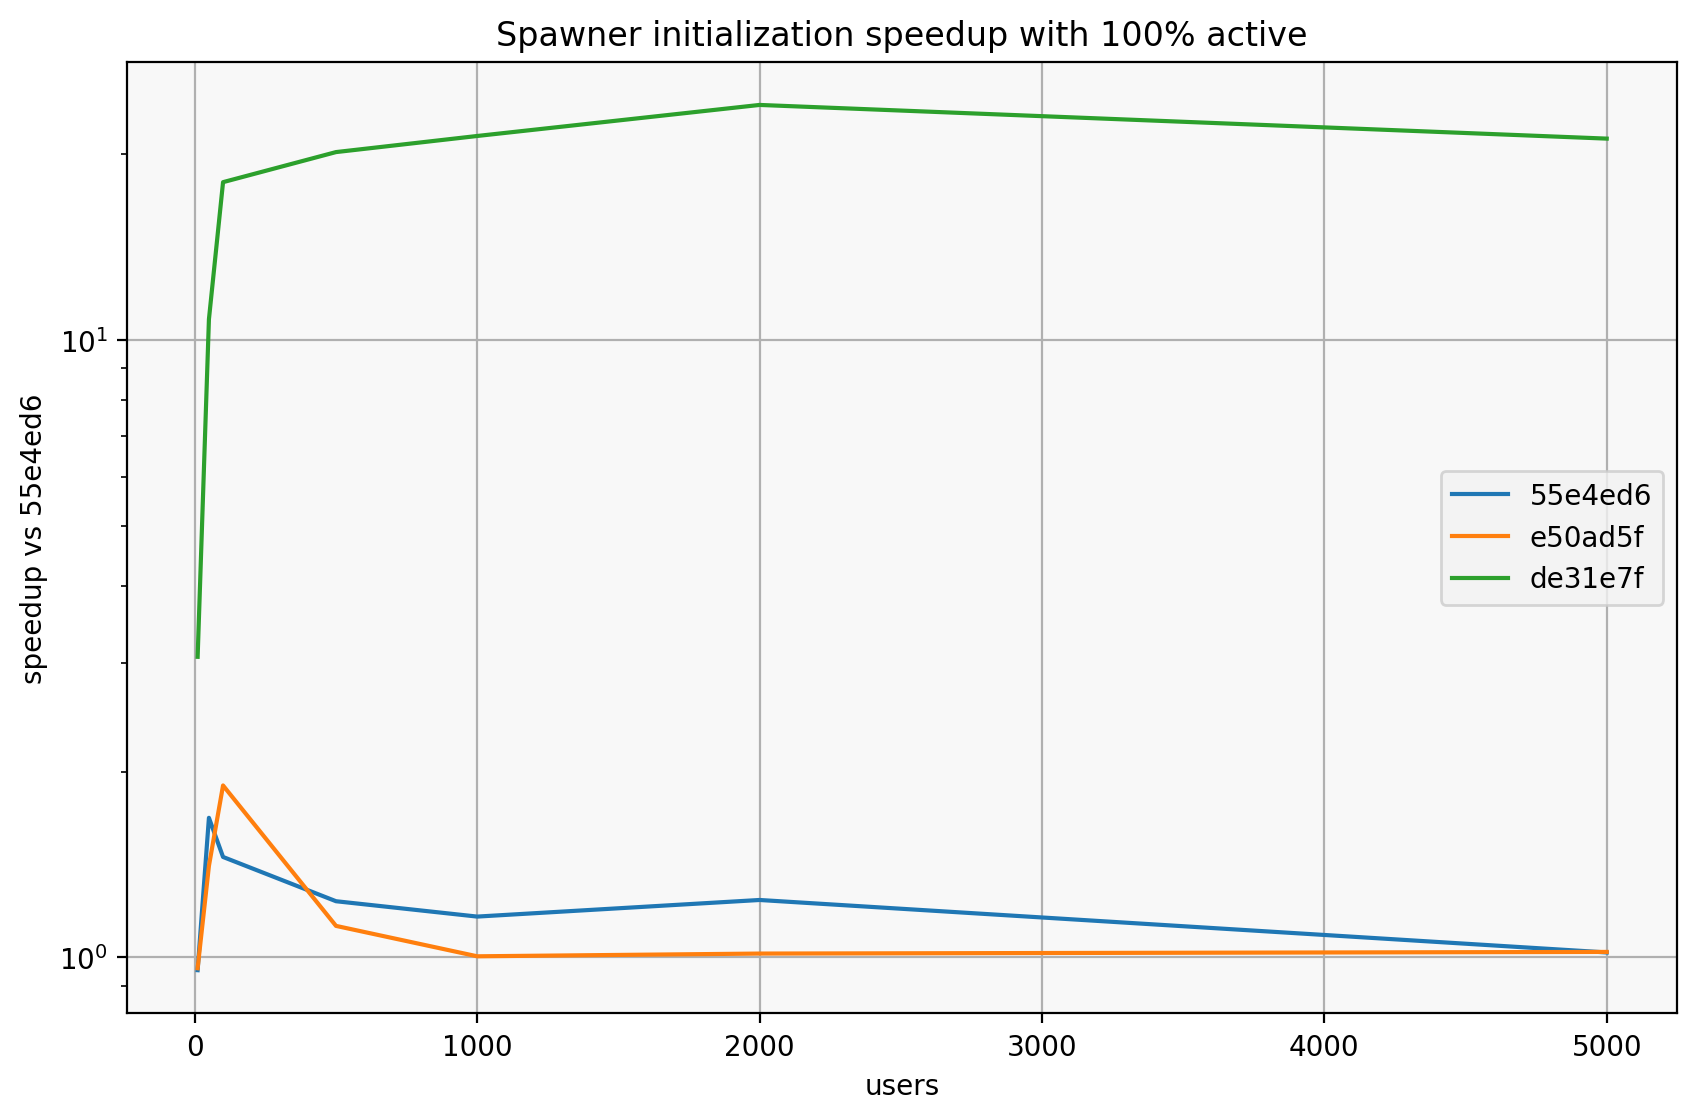

In [128]:

def plot_compare(frames, labels, y):

    baseline = frames[0]
    labels = labels[1:]
    if not isinstance(y, list):
        y = [y]
        
    relatives = [
        df[['users', 'active', 'running']] for df in frames[1:]
    ]
    for col in y:
        for active in baseline.active.unique():
            relative = baseline[['users', 'active', 'running']].copy()
            for df, name in zip(frames[1:], labels):
                relative[name] = baseline[col] / df[col]
            relative[relative.active==active].plot(x='users', y=labels)
            ax = plt.gca()
            ax.set_yscale('log')
            column_label = column_labels.get(col, col)
            plt.title(f"{column_label} speedup with {active:.0%} active")
            plt.ylabel(f"speedup vs {labels[0]}")

plot_compare(frames, names, ['startup', 'spawn'])

In [129]:
def bar_compare(frames, names, col, users=5000):
    data = []
    for name, df in zip(names, frames):
        df = df[df.users == users]
        data.append([name, df[df.active==0][col].max(), df[df.active==0.25][col].max(), df[df.active==1][col].max()])
    df = pd.DataFrame(data, columns=['commit', '0% active', '25% active', '100% active'])
    ax = plt.gca()
    df.plot.bar(ax=ax, x='commit')
    ax.set_yscale('log')
    label = labels.get(col, col)
    ax.set_title(f"{label} time for {users} users")
    ax.set_ylabel("seconds")
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(min(ymin, 1e-1), max(ymax, 1e1))
    

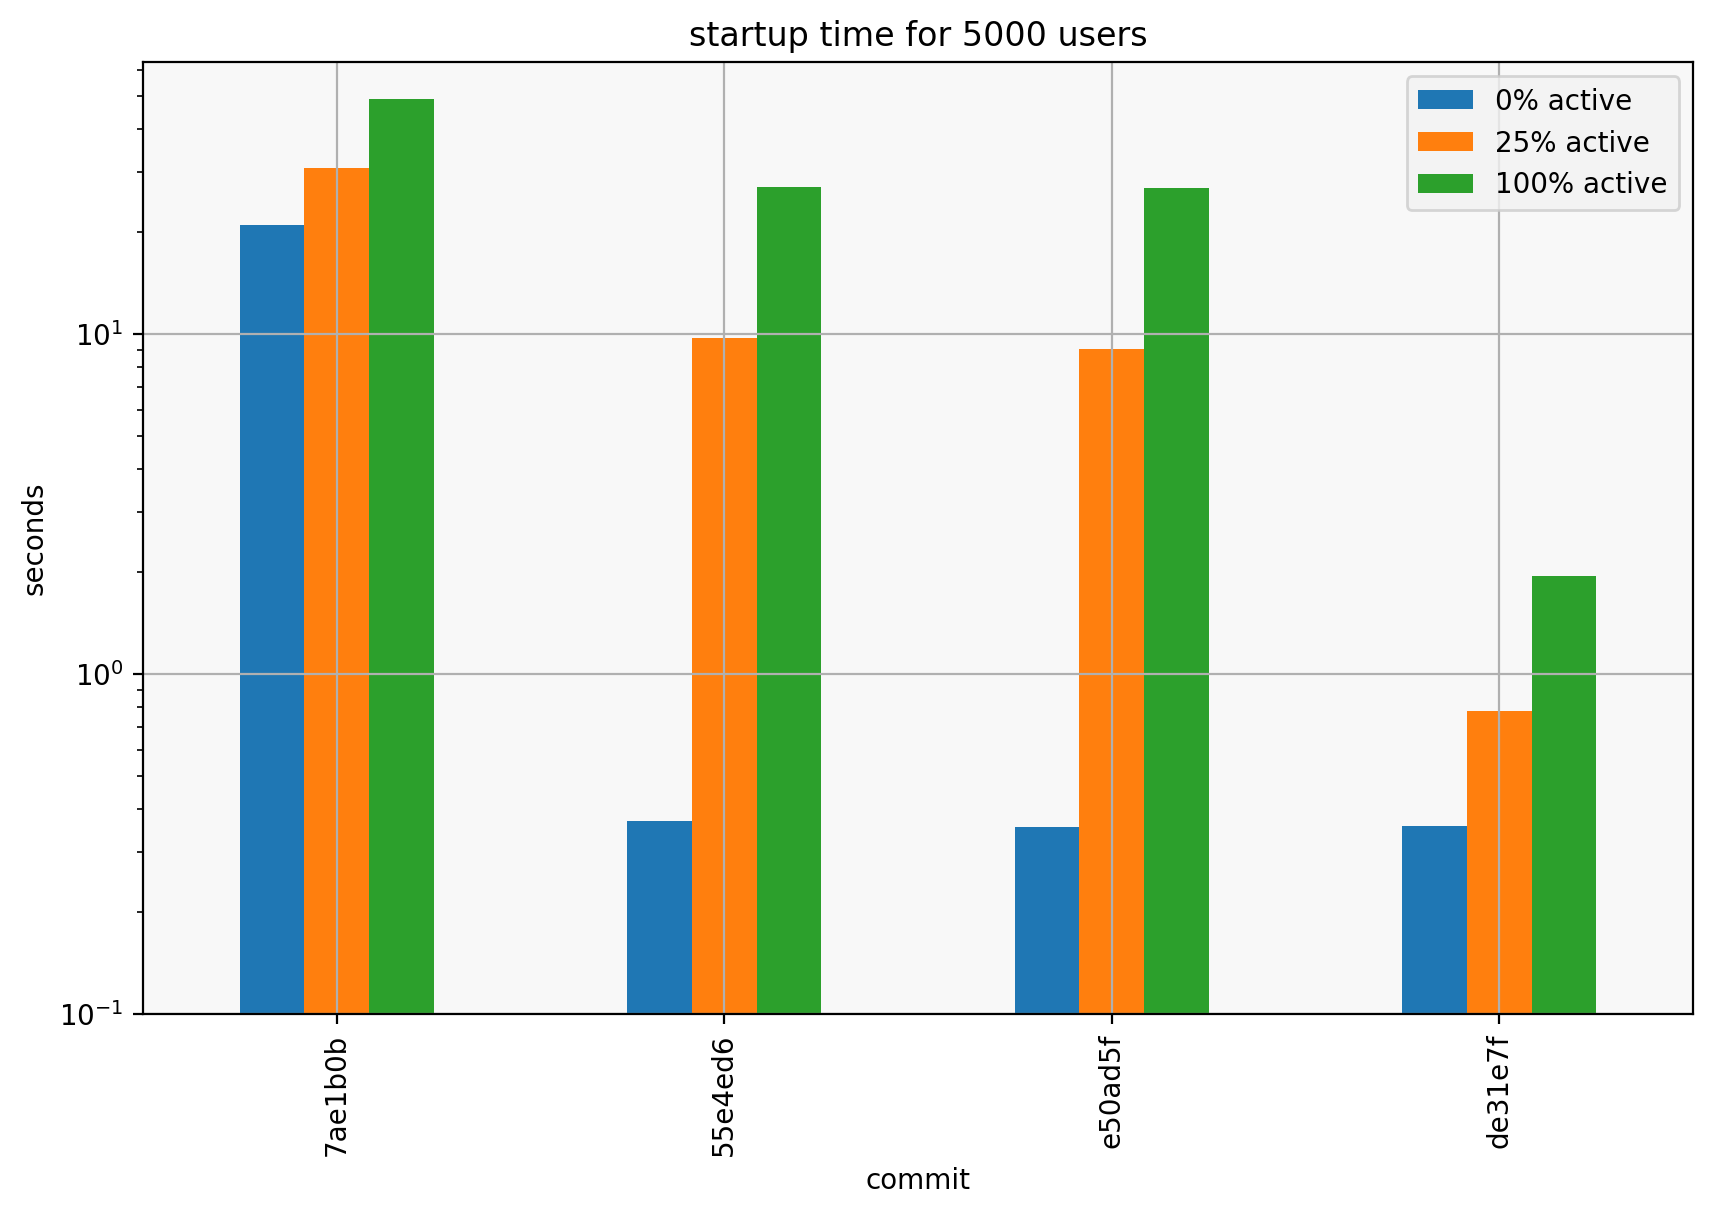

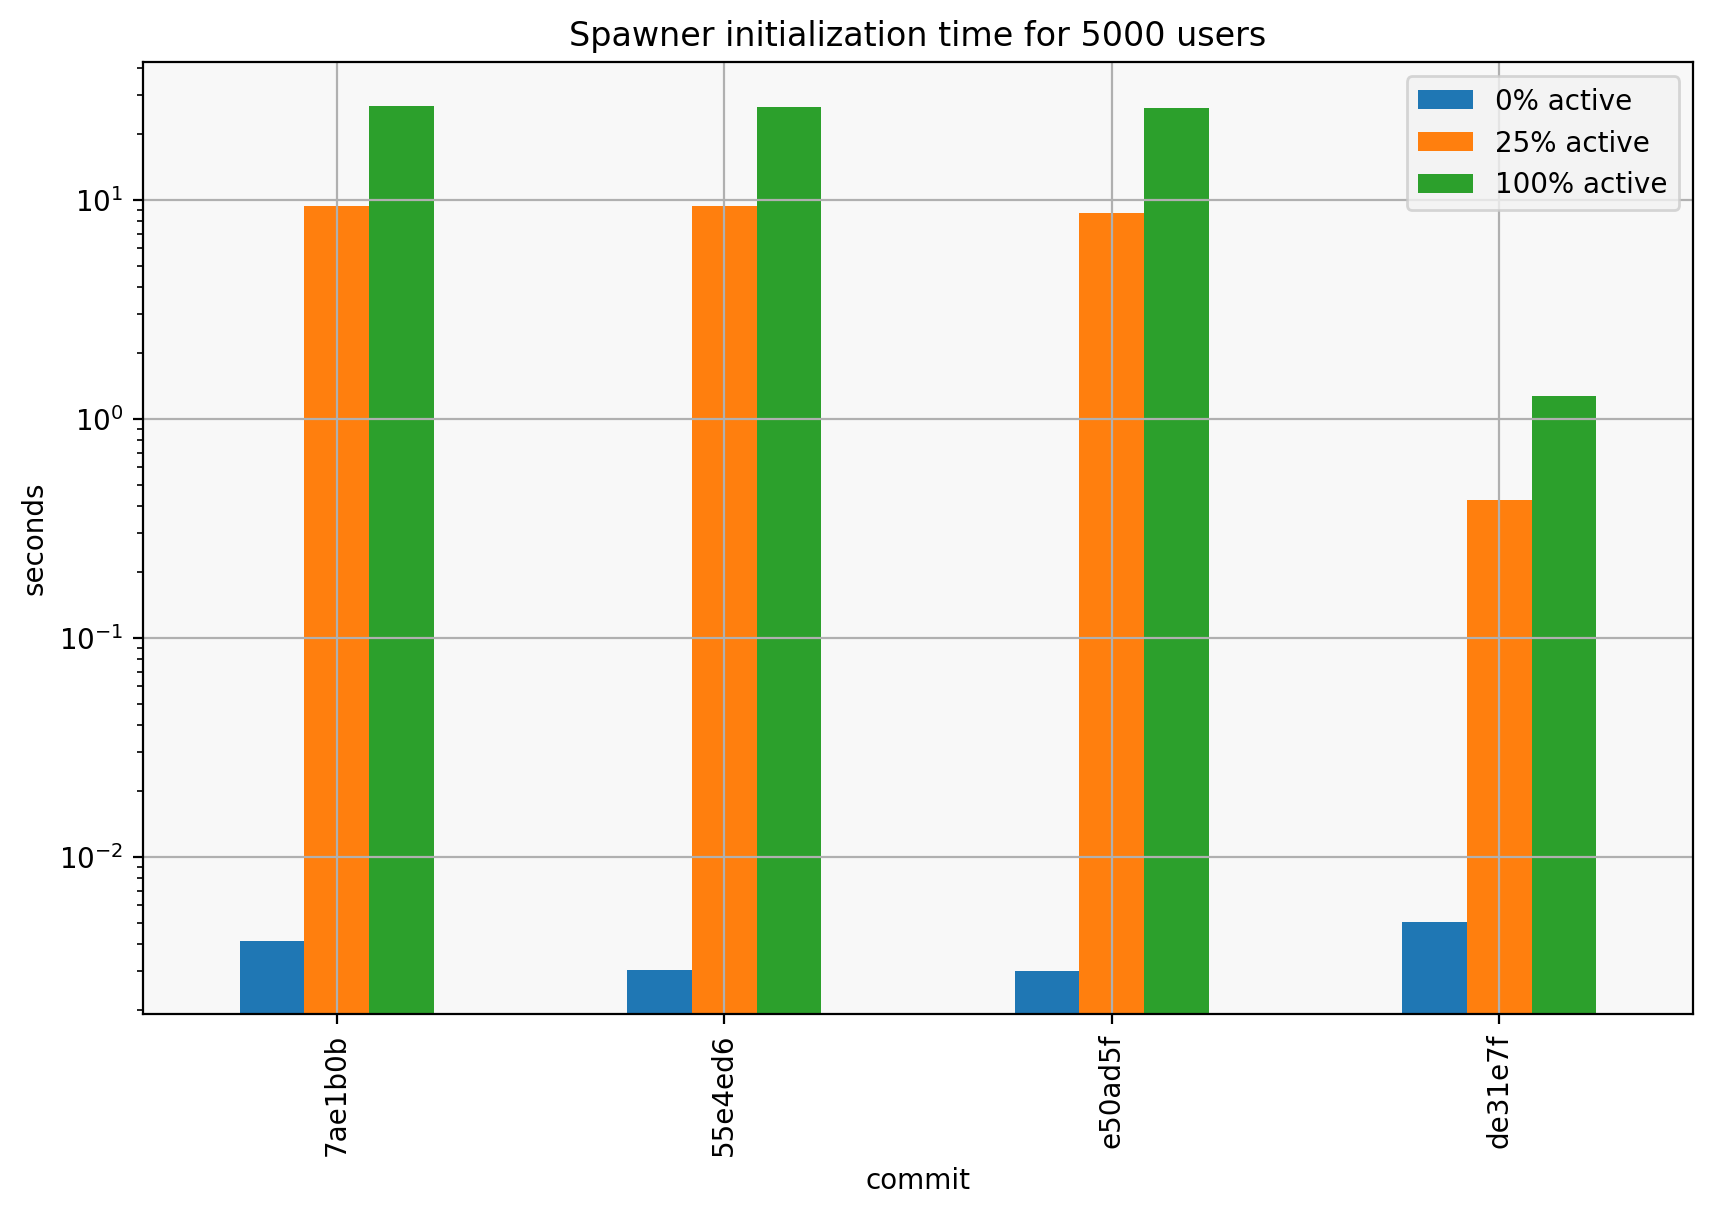

In [130]:
bar_compare(frames, names, 'startup')
plt.figure()
bar_compare(frames, names, 'spawn')
# plt.figure()
# bar_compare(frames, names, 'first_users')
# plt.figure()
# bar_compare(frames, names, 'second_users')

Summary of results:

Run with a 1ms penalty for each db execution, in order to simulate database queries over a network

- O(N) queries can be quite costly
- we've removed O(N) queries during startup,
  which were both in role assignment (O(total users)) and spawner initialization (O(running servers))
- Startup time for 5000 users with none running is reduced from ~20 seconds to less than 1 second
- Startup time for 5000 _active_ users is reduced from ~40 seconds to ~2 seconds
